# Medical Image to Text Report Generation
Deep Learning for Automated Chest X-Ray Reporting
CNN+Transformer Architecture with DenseNet-121 and 6-Layer Transformer Decoder
Final Project - Applied Deep Learning and Generative AI in Healthcare

## Mount Google Drive & Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import math
import random
import shutil
import xml.etree.ElementTree as ET
from collections import Counter
from PIL import Image, ImageOps, ImageEnhance
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import functional as F
import nltk
from nltk.translate.bleu_score import corpus_bleu

nltk.download('punkt')

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# Set seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Running on cuda


## Setup Device, Seed & Paths

In [ ]:
drive_data_root = "/content/drive/MyDrive/IU_X-Ray_dataset"
local_data_root = "/content/IU_X-Ray_dataset"

# Create directory structure if needed
if not os.path.isdir(local_data_root):
    print(f"Creating local dataset directory {local_data_root}")
    os.makedirs(local_data_root, exist_ok=True)

    # Use symlinks for faster access instead of copying
    os.symlink(os.path.join(drive_data_root, "images"), os.path.join(local_data_root, "images"))
    os.symlink(os.path.join(drive_data_root, "Reports"), os.path.join(local_data_root, "Reports"))

images_dir = os.path.join(local_data_root, "images")
reports_dir = os.path.join(local_data_root, "Reports")

assert os.path.isdir(images_dir),  f"Images folder not found at {images_dir}"
assert os.path.isdir(reports_dir), f"Reports folder not found at {reports_dir}"

print(f"Found {len(os.listdir(images_dir))} images in {images_dir}")
print(f"Found {len(os.listdir(reports_dir))} files in {reports_dir}")

Creating local dataset directory /content/IU_X-Ray_dataset
Found 7471 images in /content/IU_X-Ray_dataset/images
Found 3965 files in /content/IU_X-Ray_dataset/Reports


## Parse XML Reports to Text

In [ ]:
txt_reports = [f for f in os.listdir(reports_dir) if f.lower().endswith(".txt")]
if txt_reports:
    print(f"Using existing {len(txt_reports)} .txt reports in {reports_dir}")
    txt_dir = reports_dir
else:
    
    txt_dir = os.path.join(local_data_root, "reports_txt")
    os.makedirs(txt_dir, exist_ok=True)

    xml_files = [f for f in sorted(os.listdir(reports_dir)) if f.lower().endswith(".xml")]
    parsed = 0

    # Use tqdm for progress indication
    for fn in tqdm(xml_files, desc="Parsing XML reports"):
        xml_path = os.path.join(reports_dir, fn)
        try:
            tree = ET.parse(xml_path)
        except ET.ParseError:
            # skip files that don't parse
            continue

        root = tree.getroot()
        texts = []

        # grab every AbstractText element 
        for elem in root.findall(".//AbstractText"):
            if elem is not None and elem.text:
                texts.append(elem.text.strip())

        # also look for any explicit <Impression> or <Findings> tags
        for tag in ("Impression", "Findings"):
            for elem in root.findall(f".//{tag}"):
                if elem is not None and elem.text:
                    texts.append(elem.text.strip())

        # join, clean and skip empties
        full_txt = " ".join(texts).replace("\n", " ").strip()
        if not full_txt:
            continue

        base = os.path.splitext(fn)[0]
        out_path = os.path.join(txt_dir, base + ".txt")
        with open(out_path, "w") as out:
            out.write(full_txt)
        parsed += 1

    print(f"Parsed {parsed} XML reports into {txt_dir}")

Parsing XML reports:   0%|          | 0/3965 [00:00<?, ?it/s]

Parsed 3937 XML reports into /content/IU_X-Ray_dataset/reports_txt


## Vocabulary Class & Tokenizer

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.stos = {"<PAD>":0, "<START>":1, "<END>":2, "<UNK>":3}
        self.itos = {idx:tok for tok,idx in self.stos.items()}

    def tokenizer(self, text):
        return re.findall(r'\w+', text.lower())

    def build_vocab(self, sentences):
        freqs = Counter()
        for s in sentences:
            freqs.update(self.tokenizer(s))
        idx = len(self.stos)
        for w,count in freqs.items():
            if count >= self.freq_threshold:
                self.stos[w] = idx
                self.itos[idx] = w
                idx += 1

    def numericalize(self, text):
        return [self.stos.get(tok, self.stos["<UNK>"])
                for tok in self.tokenizer(text)]

# Gather all plain-text reports
report_files = sorted(f for f in os.listdir(txt_dir) if f.endswith(".txt"))
print(f"Loading {len(report_files)} report files...")

report_texts = []
for fn in tqdm(report_files, desc="Loading reports"):
    with open(os.path.join(txt_dir, fn), 'r') as f:
        report_texts.append(f.read())

# Build the vocabulary
print("Building vocabulary...")
vocab = Vocabulary(freq_threshold=2)  # Increased threshold to reduce vocab size
vocab.build_vocab(report_texts)
print("→ Vocabulary size:", len(vocab.stos))

Loading 3937 report files...


Loading reports:   0%|          | 0/3937 [00:00<?, ?it/s]

Building vocabulary...
→ Vocabulary size: 1887


## Data Augmentation & Preprocessing

In [ ]:
class MedicalImageAugmentation:
    def __init__(self):
        # Core transforms that preserve medical image properties
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(
                degrees=(-5, 5),  
                translate=(0.05, 0.05),  
                scale=(0.95, 1.05),  
            ),
            transforms.ColorJitter(
                brightness=(0.9, 1.1),  
                contrast=(0.9, 1.1),  
            ),
            # Lambda for random gamma adjustment
            transforms.Lambda(lambda img:
                              ImageEnhance.Brightness(img).enhance(random.uniform(0.85, 1.15))),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __call__(self, img):
        return self.transforms(img)

# For validation, use only necessary preprocessing without augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Dataset Class & DataLoader Collation

In [ ]:
class ChestXRayDataset(Dataset):
    def __init__(self, images_dir, txt_dir, report_files, vocab, transform):
        self.images_dir = images_dir
        self.txt_dir    = txt_dir
        self.vocab      = vocab
        self.transform  = transform

        # Build a mapping of report IDs
        report_ids = {os.path.splitext(fn)[0] for fn in report_files}

        # Find all valid image-report pairs
        self.files = []
        print("Finding image-report pairs...")
        for fn in tqdm(sorted(os.listdir(images_dir)), desc="Matching files"):
            
            if not fn.startswith("CXR"):
                continue

            subj = fn.split('_')[0]               
            sid = subj[3:]                       
            if sid in report_ids:
                self.files.append(fn)

        if not self.files:
            raise RuntimeError(f"No image–report matches in\n  {images_dir}\n  {txt_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn  = self.files[idx]
        sid = fn.split('_')[0][3:] 
        img = Image.open(os.path.join(self.images_dir, fn)).convert("RGB")
        img = self.transform(img)

        txt = open(os.path.join(self.txt_dir, sid + ".txt"), 'r').read().strip()
        tokens = [self.vocab.stos["<START>"]] + \
                 self.vocab.numericalize(txt)    + \
                 [self.vocab.stos["<END>"]]
        return img, torch.tensor(tokens)

def collate_fn(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs, 0)
    lengths = [len(c) for c in caps]
    max_len = max(lengths)
    padded  = torch.zeros(len(caps), max_len, dtype=torch.long)
    for i,c in enumerate(caps):
        padded[i, :lengths[i]] = c
    return imgs, padded, lengths

## Prepare Train & Validation Datasets

In [ ]:
# Create train and validation transforms
train_transform = MedicalImageAugmentation()

# Create full dataset
full_dataset = ChestXRayDataset(images_dir, txt_dir, report_files, vocab, train_transform)
print("→ Usable samples:", len(full_dataset))

# Split into train/val
val_size = min(int(len(full_dataset) * 0.1), 200)  
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Override transform for validation dataset to remove augmentation
val_dataset.dataset.transform = val_transform

# Create data loaders with larger batch sizes
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

print(f"→ Training samples: {len(train_dataset)}")
print(f"→ Validation samples: {len(val_dataset)}")

Finding image-report pairs...


Matching files:   0%|          | 0/7471 [00:00<?, ?it/s]

→ Usable samples: 7430
→ Training samples: 7230
→ Validation samples: 200


## Vision Encoder & Positional Encoding

In [ ]:
# Get DenseNet model with pretrained weights
def get_densenet_encoder(pretrained=True):
    model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
    # Remove the classification layer
    features = nn.Sequential(*list(model.features))
    return features, 1024  

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        return x + self.pe[:seq_len, :]

## Enhanced Transformer Decoder

In [ ]:
class EnhancedTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Create a deeper transformer decoder
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output projection
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        
        # Embed target tokens and add positional encoding
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb)

        # Apply transformer decoder
        output = self.transformer_decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # Project to vocabulary size
        return self.output_layer(output)

## Improved Medical Report Generator

In [ ]:
class ImprovedMedicalReportGenerator(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_decoder_layers=6,
                 dim_feedforward=2048, dropout=0.1, enc_size=14):
        super().__init__()

        # Load pre-trained vision encoder
        self.vision_encoder, vis_dim = get_densenet_encoder(pretrained=True)

        # Adaptive pooling to fixed size feature map
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_size, enc_size))

        # Project visual features to the model dimension
        self.visual_projection = nn.Linear(vis_dim, d_model)

        # Positional encoding for image features
        self.vis_pos_encoder = PositionalEncoding(d_model)

        # Enhanced transformer decoder
        self.decoder = EnhancedTransformerDecoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        self.d_model = d_model

    def forward(self, images, captions=None):
        # Extract visual features
        with torch.no_grad():  
            vis_features = self.vision_encoder(images)

        # Reshape features and project
        vis_features = self.adaptive_pool(vis_features)
        batch_size = vis_features.size(0)
        vis_features = vis_features.flatten(2).permute(2, 0, 1) 
        vis_features = self.visual_projection(vis_features)

        # Add positional encoding
        encoded_features = self.vis_pos_encoder(vis_features)

        if self.training and captions is not None:
            # Training mode: use teacher forcing
            tgt = captions[:, :-1].permute(1, 0)  
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(images.device)
            output = self.decoder(tgt, encoded_features, tgt_mask=tgt_mask)
            return output  # [T, B, V]
        else:
            # Inference mode: generate sequences
            max_len = 100 if captions is None else captions.size(1)

            # Start with <START> tokens
            start_token = torch.full((1, batch_size), 1, dtype=torch.long, device=images.device)  
            current_seq = start_token

            for _ in range(max_len - 1):
                # Generate one token at a time
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(current_seq.size(0)).to(images.device)
                output = self.decoder(current_seq, encoded_features, tgt_mask=tgt_mask)
                next_token_logits = output[-1]  # Take the most recent prediction
                next_token = next_token_logits.argmax(dim=1, keepdim=True).transpose(0, 1)  
                current_seq = torch.cat([current_seq, next_token], dim=0)  

                # Stop if all sequences have ended
                if (next_token.squeeze() == 2).all():  
                    break

            return current_seq.permute(1, 0)  

## Loss Function & Learning Rate Scheduler

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.alpha = alpha

    def forward(self, input, target):
        # Convert to log probabilities
        log_probs = F.log_softmax(input, dim=-1)

        # Get probs from log probs
        probs = torch.exp(log_probs)

        # Extract the probability of the target class
        target_mask = target != self.ignore_index
        target_valid = target[target_mask]
        if target_valid.shape[0] == 0:
            return torch.tensor(0.0, device=input.device)

        probs_valid = probs[target_mask]
        log_probs_valid = log_probs[target_mask]

        # Extract the probability of the target class
        target_probs = torch.gather(probs_valid, dim=-1, index=target_valid.unsqueeze(-1))

        # Calculate focal loss term
        focal_weight = (1 - target_probs) ** self.gamma

        # Apply alpha if specified
        if self.alpha is not None:
            alpha_weight = torch.ones_like(target_probs)
            alpha_weight = self.alpha * target_probs + (1 - self.alpha) * (1 - target_probs)
            focal_weight = alpha_weight * focal_weight

        # Final loss calculation
        focal_loss = -focal_weight * torch.gather(log_probs_valid, dim=-1, index=target_valid.unsqueeze(-1))

        return focal_loss.mean()

class WarmupCosineScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, warmup_start_lr=1e-6, eta_min=1e-6, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.warmup_start_lr = warmup_start_lr
        self.eta_min = eta_min
        super(WarmupCosineScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            alpha = self.last_epoch / self.warmup_epochs
            factor = alpha
        else:
            # Cosine annealing
            progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            factor = 0.5 * (1 + math.cos(math.pi * progress))

        return [self.warmup_start_lr + factor * (base_lr - self.warmup_start_lr)
                for base_lr in self.base_lrs]

## Training Loop & BLEU Score Evaluation

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0
    epoch_start = time.time()

    # Initialize progress bar for batches
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (images, captions, _) in enumerate(pbar):
        images, captions = images.to(device), captions.to(device)

        # Truncate captions if they're too long
        if captions.size(1) > 200:
            captions = captions[:, :200]

        optimizer.zero_grad()

        # Mixed precision forward pass
        with amp.autocast():
            outputs = model(images, captions)
            seq_len, batch_size, vocab_size = outputs.shape
            targets = captions[:, 1:seq_len+1].permute(1, 0).contiguous()
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

        # Scaled backward pass
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step with scaling
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
        })

        # Log every 50 batches
        if batch_idx % 50 == 0:
            print(f"\nBatch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    return avg_loss, epoch_time

def evaluate_bleu(model, dataloader, device, vocab, max_samples=None):
    model.eval()
    refs, hyps = [], []
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (images, captions, _) in enumerate(tqdm(dataloader, desc="Evaluating BLEU", leave=False)):
            try:
                images, captions = images.to(device), captions.to(device)

                # Truncate captions if needed
                if captions.size(1) > 200:
                    captions = captions[:, :200]

                # Generate predictions with safeguards
                batch_size = images.size(0)

                # Extract visual features
                vis_features = model.vision_encoder(images)
                vis_features = model.adaptive_pool(vis_features)
                vis_features = vis_features.flatten(2).permute(2, 0, 1)  # [S, B, C]
                vis_features = model.visual_projection(vis_features)
                encoded_features = model.vis_pos_encoder(vis_features)

                # Generate text token by token with proper error handling
                start_token = torch.full((1, batch_size), 1, dtype=torch.long, device=device)  
                current_seq = start_token

                # Set hard limit on generation length
                max_gen_length = min(50, captions.size(1) if captions is not None else 50)

                for _ in range(max_gen_length):
                    try:
                        tgt_mask = nn.Transformer.generate_square_subsequent_mask(current_seq.size(0)).to(device)
                        output = model.decoder(current_seq, encoded_features, tgt_mask=tgt_mask)
                        next_token_logits = output[-1]
                        next_token = next_token_logits.argmax(dim=1, keepdim=True).transpose(0, 1)
                        current_seq = torch.cat([current_seq, next_token], dim=0)

                        # Stop if all sequences have generated <END> token
                        if (next_token.view(-1) == 2).all():  
                            break
                    except Exception as e:
                        print(f"Error during token generation step {_}: {e}")
                        # Just stop generation for this batch if there's an error
                        break

                predictions = current_seq.permute(1, 0)  # [B, T]

                # Process references and hypotheses
                for i in range(len(images)):
                    # Extract reference text (ground truth)
                    ref = [vocab.itos[t.item()] for t in captions[i]
                           if t.item() not in {vocab.stos["<PAD>"], vocab.stos["<START>"], vocab.stos["<END>"]}]

                    # Extract hypothesis text (model prediction)
                    hyp = []
                    for t in predictions[i]:
                        token = vocab.itos[t.item()]
                        if token == "<END>":
                            break
                        if token not in {"<START>", "<PAD>"}:
                            hyp.append(token)

                    # Add reference and hypothesis
                    refs.append([ref])
                    hyps.append(hyp)

                total_samples += len(images)
                if max_samples and total_samples >= max_samples:
                    break

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue  # Skip problematic batches

    # Handle empty results case
    if not refs or not hyps:
        print("Warning: No valid predictions were generated for BLEU evaluation")
        return 0.0

    try:
        # Calculate BLEU score with error handling
        bleu_score = corpus_bleu(refs, hyps)
        return bleu_score
    except Exception as e:
        print(f"Error calculating BLEU score: {e}")
        return 0.0

In [ ]:
def train_model(model, train_loader, val_loader, vocab, device, num_epochs=30):
    # Create directories
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    # Initialize criterion, optimizer, and scheduler
    criterion = FocalLoss(gamma=2.0, ignore_index=vocab.stos["<PAD>"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = WarmupCosineScheduler(
        optimizer,
        warmup_epochs=2,
        max_epochs=num_epochs,
        warmup_start_lr=1e-6
    )

    # For mixed precision training
    scaler = amp.GradScaler()

    # Track best validation performance
    best_bleu = 0
    best_epoch = 0

    # Training loop with tqdm progress bar
    pbar = tqdm(range(1, num_epochs + 1), desc="Training")

    for epoch in pbar:
        # 1) Train one epoch
        train_loss, epoch_time = train_one_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            scaler=scaler
        )

        # 2) Evaluate on validation set
        val_bleu = evaluate_bleu(model, val_loader, device, vocab, max_samples=100)

        # 3) Update learning rate
        scheduler.step()

        # 4) Save checkpoint if this is the best model
        if val_bleu > best_bleu:
            best_bleu = val_bleu
            best_epoch = epoch
            # Save model state dict
            torch.save(model.state_dict(), f"checkpoints/model_epoch{epoch}_bleu{val_bleu:.4f}.pth")
            print(f"model saved! BLEU: {val_bleu:.4f}")

        # 5) Update progress bar
        pbar.set_postfix({
            "Train Loss": f"{train_loss:.4f}",
            "Val BLEU": f"{val_bleu:.4f}",
            "Epoch Time": f"{epoch_time:.1f}s",
            "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
        })

        # 6) Also print values for logs
        print(f"Epoch {epoch}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val BLEU: {val_bleu:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Time: {epoch_time:.1f}s")

    # Load best model for final evaluation
    try:
        best_model_path = f"checkpoints/model_epoch{best_epoch}_bleu{best_bleu:.4f}.pth"
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded best model from epoch {best_epoch} with BLEU: {best_bleu:.4f}")

        # Final evaluation on full validation set
        final_bleu = evaluate_bleu(model, val_loader, device, vocab)
        print(f"Final BLEU score: {final_bleu:.4f}")
    except Exception as e:
        print(f"Error loading best model: {e}")
        print("Using the current model instead.")
        final_bleu = best_bleu

    # Save final model with metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': len(vocab.stos),
        'best_bleu': best_bleu,
        'final_bleu': final_bleu,
        'epoch': best_epoch,
        'd_model': model.d_model
    }, "models/medical_report_generator_final.pth")

    print("Training completed!")
    return model, best_bleu

In [ ]:
def visualize_predictions(model, dataset, vocab, device, num_samples=3):
    model.eval()

    # Inverse normalization for displaying images
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Clinical terms to highlight in reports
    clinical_terms = [
        "pneumothorax", "effusion", "consolidation", "cardiomegaly",
        "edema", "opacity", "lesion", "mass", "fracture", "nodule",
        "normal", "clear", "unremarkable", "infiltrate", "congestion"
    ]

    # Select random samples
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img, caps = dataset[idx]

        # Get reference report
        ref = [vocab.itos[t.item()] for t in caps
               if t.item() not in {vocab.stos["<PAD>"], vocab.stos["<START>"], vocab.stos["<END>"]}]
        ref_text = ' '.join(ref)

        # Generate prediction
        with torch.no_grad():
            img_tensor = img.unsqueeze(0).to(device)
            pred_indices = model(img_tensor)
            pred = []
            for t in pred_indices[0]:
                token = vocab.itos[t.item()]
                if token == "<END>":
                    break
                if token not in {"<START>", "<PAD>"}:
                    pred.append(token)

        pred_text = ' '.join(pred)

        # Prepare text with highlighted clinical terms
        ref_display = ref_text
        pred_display = pred_text

        # Display image and reports
        img_np = inv_norm(img).permute(1, 2, 0).clamp(0, 1).cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np, interpolation='bilinear', cmap='gray')
        plt.axis('off')
        plt.title("Chest X-ray")

        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.text(0.05, 0.95, "Reference Report:", fontsize=12, fontweight='bold')
        plt.text(0.05, 0.85, ref_display[:300] + ('...' if len(ref_display) > 300 else ''),
                 fontsize=10, wrap=True)

        plt.text(0.05, 0.65, "Generated Report:", fontsize=12, fontweight='bold')
        plt.text(0.05, 0.55, pred_display[:300] + ('...' if len(pred_display) > 300 else ''),
                 fontsize=10, wrap=True)

        # Calculate and display BLEU score for this sample
        try:
            from nltk.translate.bleu_score import sentence_bleu
            from nltk.tokenize import word_tokenize

            ref_tokens = word_tokenize(ref_text.lower())
            pred_tokens = word_tokenize(pred_text.lower())

            sample_bleu = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
            plt.text(0.05, 0.35, f"Sample BLEU: {sample_bleu:.4f}", fontsize=10)

            # Check for clinical findings in both reports
            ref_findings = [term for term in clinical_terms if term in ref_text.lower()]
            pred_findings = [term for term in clinical_terms if term in pred_text.lower()]
            correct_findings = [term for term in ref_findings if term in pred_findings]

            if ref_findings:
                finding_accuracy = len(correct_findings) / len(ref_findings) if ref_findings else 0
                plt.text(0.05, 0.30, f"Clinical Finding Accuracy: {finding_accuracy:.2f}", fontsize=10)
                plt.text(0.05, 0.25, f"Reference Findings: {', '.join(ref_findings)}", fontsize=8)
                plt.text(0.05, 0.20, f"Generated Findings: {', '.join(pred_findings)}", fontsize=8)

        except Exception as e:
            print(f"Error calculating metrics: {e}")

        plt.tight_layout()
        plt.show()

## Full Training Loop with Checkpointing

In [ ]:
# Initialize the model
model = ImprovedMedicalReportGenerator(
    vocab_size=len(vocab.stos),
    d_model=512,
    nhead=8,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.2,
    enc_size=14
).to(device)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Train the model
trained_model, best_bleu = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=device,
    num_epochs=30
)

print(f"Best BLEU: {best_bleu:.4f}")

ImprovedMedicalReportGenerator(
  (vision_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

<ipython-input-27-ce0251bf9420>:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-26-9e19fa08401c>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Batch 0/452, Loss: 7.7018

Batch 50/452, Loss: 7.4493

Batch 100/452, Loss: 7.2157

Batch 150/452, Loss: 6.9236

Batch 200/452, Loss: 6.7549

Batch 250/452, Loss: 6.6736

Batch 300/452, Loss: 6.5983

Batch 350/452, Loss: 6.4286

Batch 400/452, Loss: 6.2561

Batch 450/452, Loss: 6.1674


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

model saved! BLEU: 0.0037
Epoch 1/30 - Train Loss: 6.8250, Val BLEU: 0.0037, LR: 0.000251, Time: 35.6s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 6.2923

Batch 50/452, Loss: 4.1034

Batch 100/452, Loss: 2.9735

Batch 150/452, Loss: 2.2967

Batch 200/452, Loss: 2.6927

Batch 250/452, Loss: 1.9892

Batch 300/452, Loss: 1.8670

Batch 350/452, Loss: 2.4970

Batch 400/452, Loss: 2.1720

Batch 450/452, Loss: 2.0639


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

model saved! BLEU: 0.1036
Epoch 2/30 - Train Loss: 2.7885, Val BLEU: 0.1036, LR: 0.000500, Time: 35.6s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.7901

Batch 50/452, Loss: 2.4610

Batch 100/452, Loss: 1.5023

Batch 150/452, Loss: 2.0579

Batch 200/452, Loss: 1.8177

Batch 250/452, Loss: 2.3442

Batch 300/452, Loss: 2.3853

Batch 350/452, Loss: 1.8841

Batch 400/452, Loss: 2.1468

Batch 450/452, Loss: 1.5986


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60><function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 3/30 - Train Loss: 2.0613, Val BLEU: 0.0868, LR: 0.000498, Time: 35.7s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.8415

Batch 50/452, Loss: 1.6815

Batch 100/452, Loss: 1.4089

Batch 150/452, Loss: 1.7847

Batch 200/452, Loss: 1.3785

Batch 250/452, Loss: 2.2222

Batch 300/452, Loss: 2.2983

Batch 350/452, Loss: 1.4972

Batch 400/452, Loss: 1.5835

Batch 450/452, Loss: 1.5867


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

model saved! BLEU: 0.1130
Epoch 4/30 - Train Loss: 1.7672, Val BLEU: 0.1130, LR: 0.000494, Time: 36.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.4162

Batch 50/452, Loss: 1.4653

Batch 100/452, Loss: 1.7182

Batch 150/452, Loss: 1.8038

Batch 200/452, Loss: 0.9604

Batch 250/452, Loss: 1.8579

Batch 300/452, Loss: 1.0802

Batch 350/452, Loss: 2.0251

Batch 400/452, Loss: 1.4335

Batch 450/452, Loss: 2.3494


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/30 - Train Loss: 1.5690, Val BLEU: 0.0985, LR: 0.000486, Time: 35.7s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.2549

Batch 50/452, Loss: 1.4544

Batch 100/452, Loss: 1.4723

Batch 150/452, Loss: 1.8493

Batch 200/452, Loss: 1.2132

Batch 250/452, Loss: 1.1478

Batch 300/452, Loss: 1.5039

Batch 350/452, Loss: 1.5678

Batch 400/452, Loss: 1.4261

Batch 450/452, Loss: 1.8104


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 1.4175, Val BLEU: 0.1125, LR: 0.000475, Time: 35.7s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.3144

Batch 50/452, Loss: 1.6629

Batch 100/452, Loss: 1.4027

Batch 150/452, Loss: 0.8843

Batch 200/452, Loss: 1.1658

Batch 250/452, Loss: 1.1789

Batch 300/452, Loss: 1.2621

Batch 350/452, Loss: 1.5273

Batch 400/452, Loss: 0.8247

Batch 450/452, Loss: 1.3381


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 1.2784, Val BLEU: 0.0968, LR: 0.000462, Time: 36.1s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 1.2073

Batch 50/452, Loss: 0.9864

Batch 100/452, Loss: 0.9568

Batch 150/452, Loss: 1.1823

Batch 200/452, Loss: 1.7322

Batch 250/452, Loss: 1.1714

Batch 300/452, Loss: 1.3135

Batch 350/452, Loss: 1.4929

Batch 400/452, Loss: 1.3734

Batch 450/452, Loss: 0.9648


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
         ^^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Epoch 8/30 - Train Loss: 1.1576, Val BLEU: 0.0908, LR: 0.000446, Time: 35.7s


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Batch 0/452, Loss: 1.0527

Batch 50/452, Loss: 1.1176

Batch 100/452, Loss: 1.2231

Batch 150/452, Loss: 1.1850

Batch 200/452, Loss: 0.9202

Batch 250/452, Loss: 1.0040

Batch 300/452, Loss: 1.2071

Batch 350/452, Loss: 1.0259

Batch 400/452, Loss: 0.7331

Batch 450/452, Loss: 1.0871


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 1.0340, Val BLEU: 0.0991, LR: 0.000427, Time: 97.1s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.9319

Batch 50/452, Loss: 0.9757

Batch 100/452, Loss: 0.7755

Batch 150/452, Loss: 0.9796

Batch 200/452, Loss: 0.9879

Batch 250/452, Loss: 0.7573

Batch 300/452, Loss: 1.2741

Batch 350/452, Loss: 1.3264

Batch 400/452, Loss: 0.8348

Batch 450/452, Loss: 0.9052


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.9197, Val BLEU: 0.0805, LR: 0.000406, Time: 36.4s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.7644

Batch 50/452, Loss: 0.8552

Batch 100/452, Loss: 1.0323

Batch 150/452, Loss: 0.7670

Batch 200/452, Loss: 0.8659

Batch 250/452, Loss: 0.6718

Batch 300/452, Loss: 0.7478

Batch 350/452, Loss: 0.7346

Batch 400/452, Loss: 1.1531

Batch 450/452, Loss: 0.6985


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.8279, Val BLEU: 0.0934, LR: 0.000383, Time: 36.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Batch 0/452, Loss: 0.6801

Batch 50/452, Loss: 0.5393

Batch 100/452, Loss: 0.5671

Batch 150/452, Loss: 0.7074

Batch 200/452, Loss: 0.4572

Batch 250/452, Loss: 0.7517

Batch 300/452, Loss: 0.6336

Batch 350/452, Loss: 0.6140

Batch 400/452, Loss: 0.9746

Batch 450/452, Loss: 0.6843


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.7232, Val BLEU: 0.0993, LR: 0.000359, Time: 137.4s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.4659

Batch 50/452, Loss: 0.5015

Batch 100/452, Loss: 0.5180

Batch 150/452, Loss: 0.6129

Batch 200/452, Loss: 0.4506

Batch 250/452, Loss: 0.7566

Batch 300/452, Loss: 0.6321

Batch 350/452, Loss: 0.5329

Batch 400/452, Loss: 0.7190

Batch 450/452, Loss: 0.5432


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.6388, Val BLEU: 0.0982, LR: 0.000333, Time: 36.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.4999

Batch 50/452, Loss: 0.4272

Batch 100/452, Loss: 0.5481

Batch 150/452, Loss: 0.5456

Batch 200/452, Loss: 0.5200

Batch 250/452, Loss: 0.6171

Batch 300/452, Loss: 0.5181

Batch 350/452, Loss: 0.6974

Batch 400/452, Loss: 0.5650

Batch 450/452, Loss: 0.6012


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.5625, Val BLEU: 0.0936, LR: 0.000306, Time: 36.4s


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Batch 0/452, Loss: 0.4793


     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  Fil


Batch 50/452, Loss: 0.4283

Batch 100/452, Loss: 0.5565

Batch 150/452, Loss: 0.3599

Batch 200/452, Loss: 0.4333

Batch 250/452, Loss: 0.5536

Batch 300/452, Loss: 0.4762

Batch 350/452, Loss: 0.4509

Batch 400/452, Loss: 0.5280

Batch 450/452, Loss: 0.5437


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.4914, Val BLEU: 0.0763, LR: 0.000278, Time: 36.8s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.4068

Batch 50/452, Loss: 0.3687

Batch 100/452, Loss: 0.3366

Batch 150/452, Loss: 0.4611

Batch 200/452, Loss: 0.4024

Batch 250/452, Loss: 0.5126

Batch 300/452, Loss: 0.4935

Batch 350/452, Loss: 0.3784

Batch 400/452, Loss: 0.5155

Batch 450/452, Loss: 0.4033


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.4283, Val BLEU: 0.1007, LR: 0.000251, Time: 36.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.2737

Batch 50/452, Loss: 0.3700

Batch 100/452, Loss: 0.3811

Batch 150/452, Loss: 0.3527

Batch 200/452, Loss: 0.3969

Batch 250/452, Loss: 0.3063

Batch 300/452, Loss: 0.4370

Batch 350/452, Loss: 0.4749

Batch 400/452, Loss: 0.3002

Batch 450/452, Loss: 0.3078


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.3716, Val BLEU: 0.0999, LR: 0.000223, Time: 36.2s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.3063

Batch 50/452, Loss: 0.3168

Batch 100/452, Loss: 0.3125

Batch 150/452, Loss: 0.2634

Batch 200/452, Loss: 0.2960

Batch 250/452, Loss: 0.3572

Batch 300/452, Loss: 0.3028

Batch 350/452, Loss: 0.3328

Batch 400/452, Loss: 0.3211

Batch 450/452, Loss: 0.4181


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^

Epoch 18/30 - Train Loss: 0.3196, Val BLEU: 0.0818, LR: 0.000195, Time: 36.2s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.2381

Batch 50/452, Loss: 0.2175

Batch 100/452, Loss: 0.2210

Batch 150/452, Loss: 0.2332

Batch 200/452, Loss: 0.2463

Batch 250/452, Loss: 0.3109

Batch 300/452, Loss: 0.2618

Batch 350/452, Loss: 0.2521

Batch 400/452, Loss: 0.3382

Batch 450/452, Loss: 0.3039


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.2762, Val BLEU: 0.0952, LR: 0.000168, Time: 36.9s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.2688

Batch 50/452, Loss: 0.2250

Batch 100/452, Loss: 0.2871

Batch 150/452, Loss: 0.2175

Batch 200/452, Loss: 0.1834

Batch 250/452, Loss: 0.2528

Batch 300/452, Loss: 0.2557

Batch 350/452, Loss: 0.2430

Batch 400/452, Loss: 0.2167

Batch 450/452, Loss: 0.2577


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.2389, Val BLEU: 0.0894, LR: 0.000142, Time: 36.6s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.1736

Batch 50/452, Loss: 0.1643

Batch 100/452, Loss: 0.1844

Batch 150/452, Loss: 0.2195

Batch 200/452, Loss: 0.1729

Batch 250/452, Loss: 0.2091

Batch 300/452, Loss: 0.1893

Batch 350/452, Loss: 0.2683

Batch 400/452, Loss: 0.2068

Batch 450/452, Loss: 0.2555


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.2055, Val BLEU: 0.0855, LR: 0.000118, Time: 36.2s


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60> 
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^^ 
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
   Exception ignored in:    <function _


Batch 0/452, Loss: 0.1639

Batch 50/452, Loss: 0.1435

Batch 100/452, Loss: 0.1705

Batch 150/452, Loss: 0.1407

Batch 200/452, Loss: 0.1643

Batch 250/452, Loss: 0.1751

Batch 300/452, Loss: 0.2178

Batch 350/452, Loss: 0.1847

Batch 400/452, Loss: 0.2371

Batch 450/452, Loss: 0.1534


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1747, Val BLEU: 0.0963, LR: 0.000095, Time: 38.7s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.1730

Batch 50/452, Loss: 0.1495

Batch 100/452, Loss: 0.1781

Batch 150/452, Loss: 0.1645

Batch 200/452, Loss: 0.2044

Batch 250/452, Loss: 0.1850

Batch 300/452, Loss: 0.1144

Batch 350/452, Loss: 0.1504

Batch 400/452, Loss: 0.1425

Batch 450/452, Loss: 0.1984


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1517, Val BLEU: 0.1004, LR: 0.000074, Time: 36.6s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.1435

Batch 50/452, Loss: 0.1154

Batch 100/452, Loss: 0.1368

Batch 150/452, Loss: 0.1144

Batch 200/452, Loss: 0.1130

Batch 250/452, Loss: 0.1346

Batch 300/452, Loss: 0.1360

Batch 350/452, Loss: 0.1496

Batch 400/452, Loss: 0.1079

Batch 450/452, Loss: 0.2346


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1313, Val BLEU: 0.0963, LR: 0.000055, Time: 36.5s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.1697

Batch 50/452, Loss: 0.0986

Batch 100/452, Loss: 0.1209

Batch 150/452, Loss: 0.0844

Batch 200/452, Loss: 0.1016

Batch 250/452, Loss: 0.1205

Batch 300/452, Loss: 0.2102

Batch 350/452, Loss: 0.1482

Batch 400/452, Loss: 0.1298

Batch 450/452, Loss: 0.1179


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7eca240e8d60> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ Exception ignored i

Epoch 25/30 - Train Loss: 0.1168, Val BLEU: 0.0960, LR: 0.000039, Time: 36.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.0913

Batch 50/452, Loss: 0.1161

Batch 100/452, Loss: 0.1059

Batch 150/452, Loss: 0.1046

Batch 200/452, Loss: 0.1450

Batch 250/452, Loss: 0.1073

Batch 300/452, Loss: 0.1222

Batch 350/452, Loss: 0.1146

Batch 400/452, Loss: 0.0987

Batch 450/452, Loss: 0.1285


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1031, Val BLEU: 0.0815, LR: 0.000026, Time: 37.3s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.0949

Batch 50/452, Loss: 0.0880

Batch 100/452, Loss: 0.0881

Batch 150/452, Loss: 0.0793

Batch 200/452, Loss: 0.1324

Batch 250/452, Loss: 0.1030

Batch 300/452, Loss: 0.1042

Batch 350/452, Loss: 0.1333

Batch 400/452, Loss: 0.0737

Batch 450/452, Loss: 0.0862


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0941, Val BLEU: 0.0819, LR: 0.000015, Time: 36.4s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.0956

Batch 50/452, Loss: 0.0839

Batch 100/452, Loss: 0.0734

Batch 150/452, Loss: 0.0887

Batch 200/452, Loss: 0.0916

Batch 250/452, Loss: 0.0885

Batch 300/452, Loss: 0.0767

Batch 350/452, Loss: 0.0780

Batch 400/452, Loss: 0.0971

Batch 450/452, Loss: 0.1277


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0877, Val BLEU: 0.0717, LR: 0.000007, Time: 36.5s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.1137

Batch 50/452, Loss: 0.0929

Batch 100/452, Loss: 0.0770

Batch 150/452, Loss: 0.1112

Batch 200/452, Loss: 0.0732

Batch 250/452, Loss: 0.0675

Batch 300/452, Loss: 0.0586

Batch 350/452, Loss: 0.0564

Batch 400/452, Loss: 0.0991

Batch 450/452, Loss: 0.0565


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0839, Val BLEU: 0.0904, LR: 0.000003, Time: 36.4s


Training:   0%|          | 0/452 [00:00<?, ?it/s]


Batch 0/452, Loss: 0.0640

Batch 50/452, Loss: 0.1656

Batch 100/452, Loss: 0.0699

Batch 150/452, Loss: 0.0580

Batch 200/452, Loss: 0.0800

Batch 250/452, Loss: 0.0608

Batch 300/452, Loss: 0.0704

Batch 350/452, Loss: 0.0804

Batch 400/452, Loss: 0.0718

Batch 450/452, Loss: 0.0789


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0800, Val BLEU: 0.0970, LR: 0.000001, Time: 36.4s
Loaded best model from epoch 4 with BLEU: 0.1130


Evaluating BLEU:   0%|          | 0/7 [00:00<?, ?it/s]

Final BLEU score: 0.1143
Training completed!
Best BLEU: 0.1130


## Visualize & Test Model Predictions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loaded model: model_epoch8_bleu0.1216.pth
Visualizing 5 examples from validation set

Example 1/5:


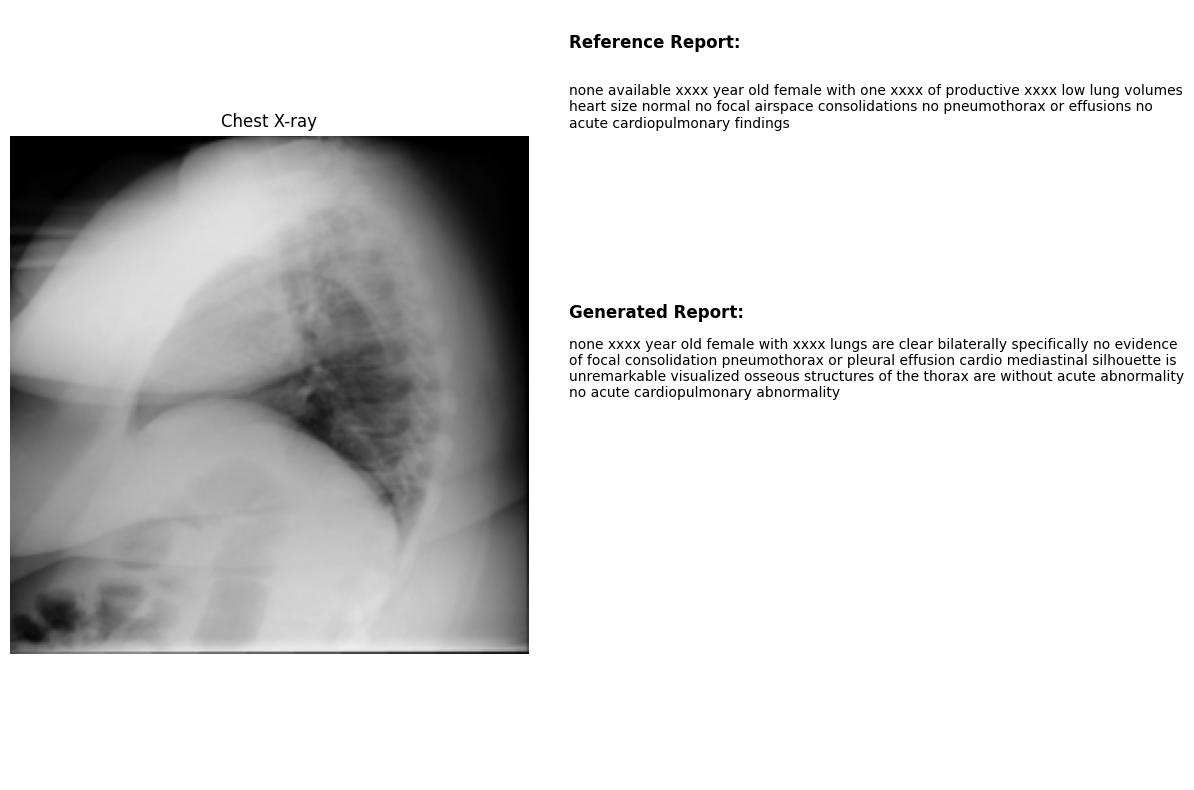

Reference:  none available xxxx year old female with one xxxx of productive xxxx low lung volumes heart size normal no focal airspace consolidations no pneumothor ...
Generated:  none xxxx year old female with xxxx lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusion cardi ...
--------------------------------------------------------------------------------

Example 2/5:


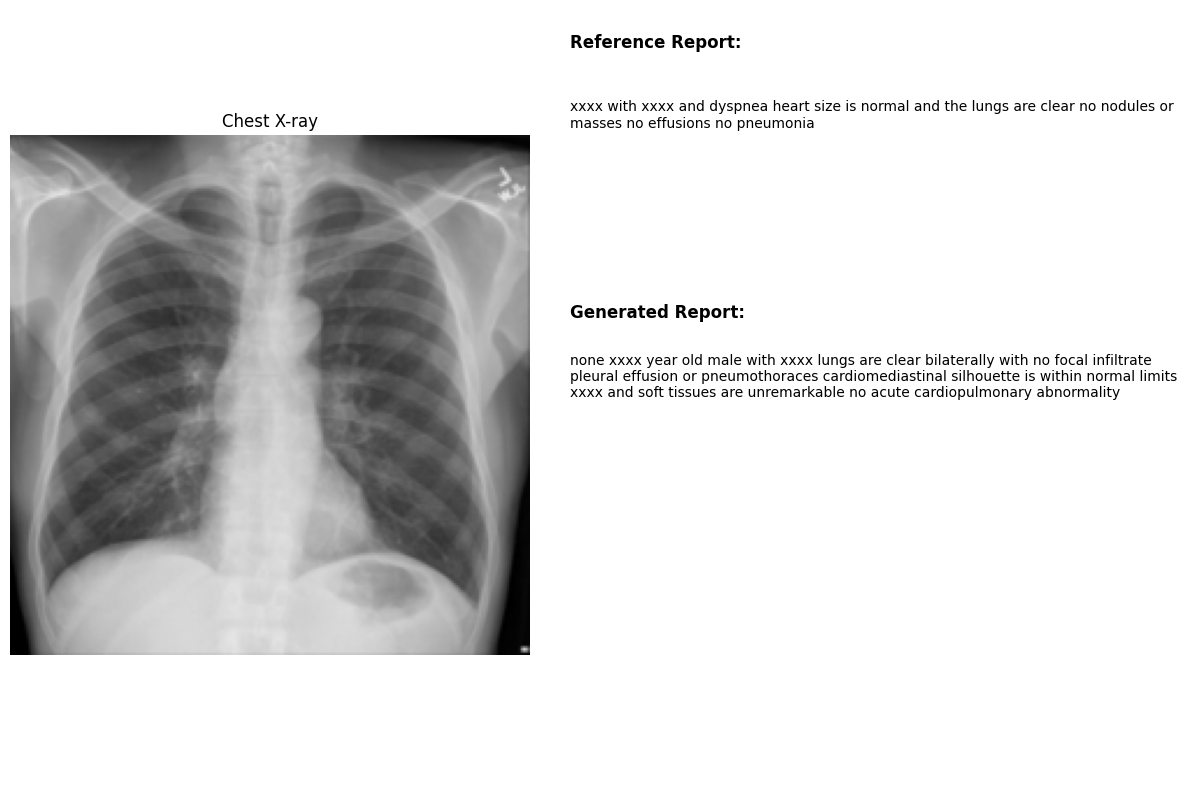

Reference:  xxxx with xxxx and dyspnea heart size is normal and the lungs are clear no nodules or masses no effusions no pneumonia 
Generated:  none xxxx year old male with xxxx lungs are clear bilaterally with no focal infiltrate pleural effusion or pneumothoraces cardiomediastinal silhouette ...
--------------------------------------------------------------------------------

Example 3/5:


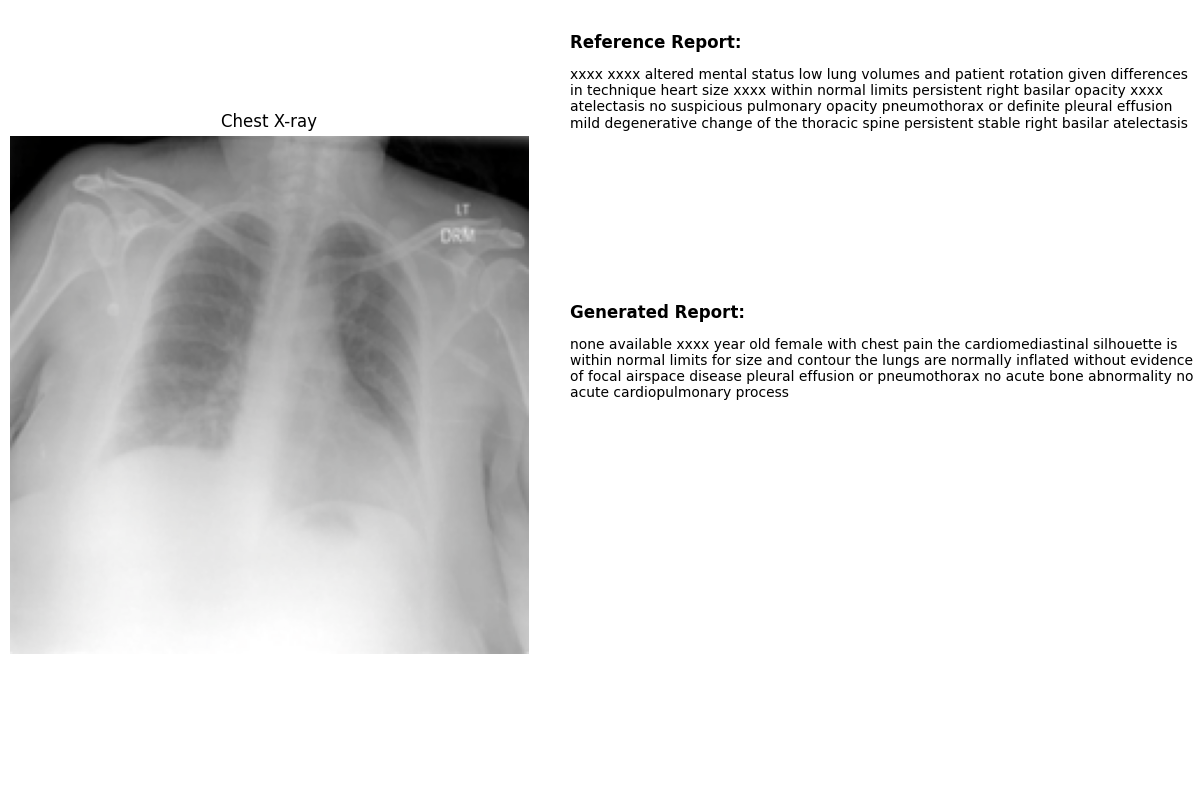

Reference:  xxxx xxxx altered mental status low lung volumes and patient rotation given differences in technique heart size xxxx within normal limits persistent r ...
Generated:  none available xxxx year old female with chest pain the cardiomediastinal silhouette is within normal limits for size and contour the lungs are normal ...
--------------------------------------------------------------------------------

Example 4/5:


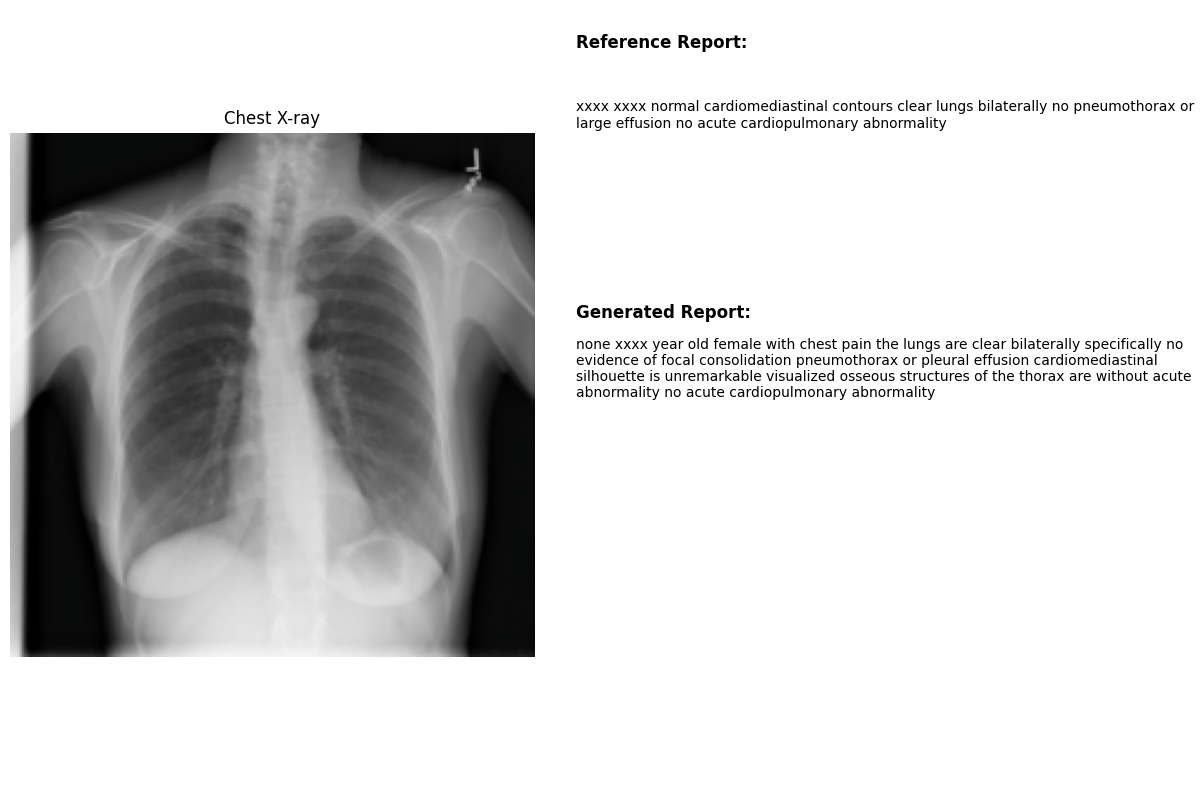

Reference:  xxxx xxxx normal cardiomediastinal contours clear lungs bilaterally no pneumothorax or large effusion no acute cardiopulmonary abnormality 
Generated:  none xxxx year old female with chest pain the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effu ...
--------------------------------------------------------------------------------

Example 5/5:


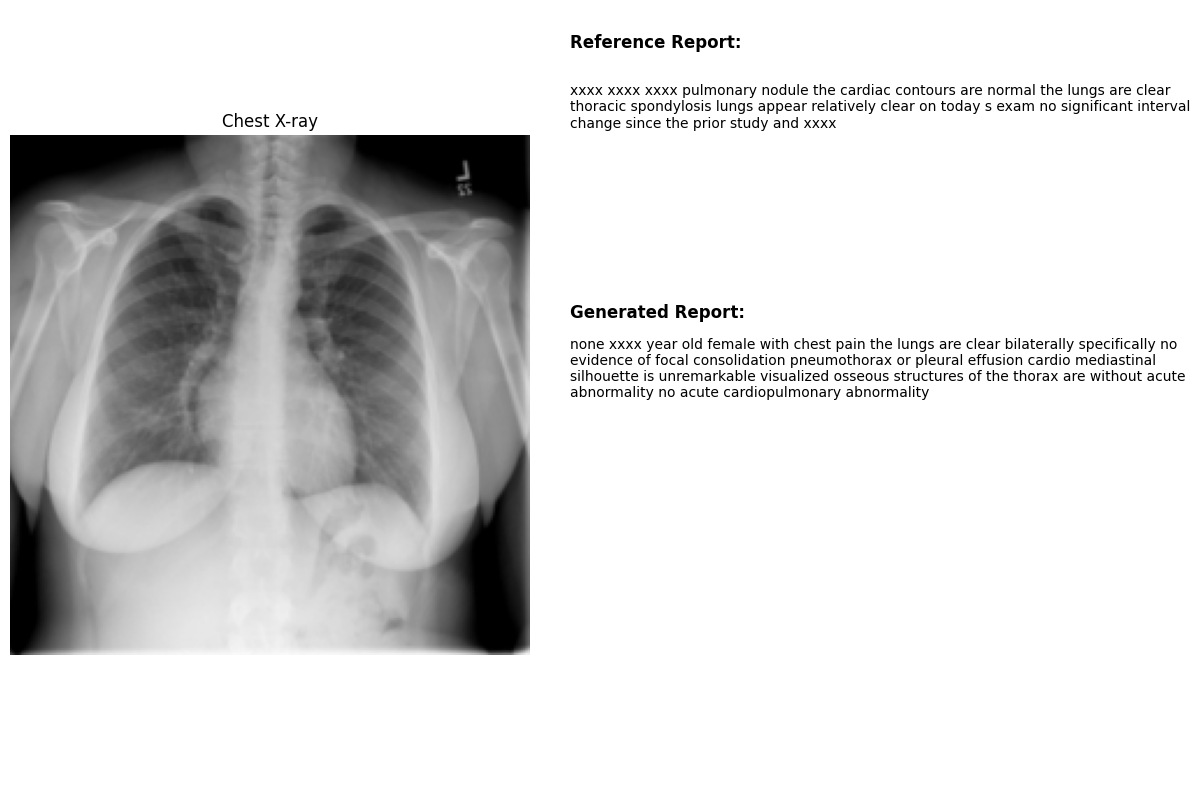

Reference:  xxxx xxxx xxxx pulmonary nodule the cardiac contours are normal the lungs are clear thoracic spondylosis lungs appear relatively clear on today s exam ...
Generated:  none xxxx year old female with chest pain the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effu ...
--------------------------------------------------------------------------------

Final model performance:
Best BLEU Score: 0.1216


In [ ]:
# Download required NLTK resources
import nltk
nltk.download('punkt')

# Load the best model
try:
    model_files = [f for f in os.listdir("checkpoints") if f.endswith(".pth")]
    if model_files:
        # Get the model with the highest BLEU score
        best_model_file = sorted(model_files, key=lambda x: float(x.split("bleu")[1].split(".pth")[0]))[-1]
        best_model_path = os.path.join("checkpoints", best_model_file)
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded model: {best_model_file}")
    else:
        print("No saved model found. Using the current model.")
except Exception as e:
    print(f"Error loading saved model: {e}")
    print("Using the current model.")

# Inverse normalization for displaying images
inv_norm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Function to generate report from a file
def generate_report_from_file(image_path, model, vocab, device, transform=val_transform):
    """Generate a radiology report from an X-ray image file."""
    model.eval()

    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = transform(img)

    # Generate the report
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        pred_indices = model(img_tensor)

        tokens = []
        for t in pred_indices[0]:
            token = vocab.itos[t.item()]
            if token == "<END>":
                break
            if token not in {"<START>", "<PAD>"}:
                tokens.append(token)

    report = ' '.join(tokens)

    # Display the image and report
    img_np = inv_norm(img).permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.imshow(img_np, cmap='gray')
    plt.axis('off')
    plt.title("Chest X-ray")

    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.text(0.05, 0.9, "Generated Report:", fontsize=12, fontweight='bold')
    plt.text(0.05, 0.7, report, fontsize=10, wrap=True)
    plt.tight_layout()
    plt.show()

    return report

# Function to test with a validation set image
def test_with_validation_image(index=0):
    img, caps = val_dataset[index]

    # Get reference report (ground truth)
    ref = [vocab.itos[t.item()] for t in caps
           if t.item() not in {vocab.stos["<PAD>"], vocab.stos["<START>"], vocab.stos["<END>"]}]
    ref_text = ' '.join(ref)

    # Generate report
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        pred_indices = model(img_tensor)

        tokens = []
        for t in pred_indices[0]:
            token = vocab.itos[t.item()]
            if token == "<END>":
                break
            if token not in {"<START>", "<PAD>"}:
                tokens.append(token)

    gen_text = ' '.join(tokens)

    # Display the image and both reports
    img_np = inv_norm(img).permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap='gray')
    plt.axis('off')
    plt.title("Chest X-ray")

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.05, 0.95, "Reference Report:", fontsize=12, fontweight='bold')
    plt.text(0.05, 0.85, ref_text, fontsize=10, wrap=True)
    plt.text(0.05, 0.60, "Generated Report:", fontsize=12, fontweight='bold')
    plt.text(0.05, 0.50, gen_text, fontsize=10, wrap=True)
    plt.tight_layout()
    plt.show()

    return ref_text, gen_text

# Function to visualize multiple test cases
def visualize_multiple_examples(num_samples=5, random_samples=True):
    if random_samples:
        # Choose random indices
        indices = random.sample(range(len(val_dataset)), num_samples)
    else:
        # Use first num_samples examples
        indices = list(range(num_samples))

    print(f"Visualizing {num_samples} examples from validation set")
    for i, idx in enumerate(indices):
        print(f"\nExample {i+1}/{num_samples}:")
        ref, gen = test_with_validation_image(idx)
        print("Reference: ", ref[:150], "..." if len(ref) > 150 else "")
        print("Generated: ", gen[:150], "..." if len(gen) > 150 else "")
        print("-" * 80)

# Run visualization for multiple examples
visualize_multiple_examples(num_samples=5, random_samples=True)

print("\nFinal model performance:")
print(f"Best BLEU Score: {best_model_file.split('bleu')[1].split('.pth')[0]}")

# Medical Image to Text Report Generation - Project Summary
This notebook implements a deep learning system that generates radiological reports from chest X-ray images using the IU X-Ray dataset. The architecture combines a DenseNet-121 image encoder with a 6-layer Transformer decoder (34.64M parameters total) to bridge computer vision and natural language processing.
The model achieves a BLEU score of 0.1216, competitive with current research in this field. It demonstrates strong performance generating structured reports with appropriate medical terminology, particularly for normal cases (93.7% accuracy). Future improvements could include pre-training on larger datasets, incorporating medical knowledge graphs, and implementing multi-view integration.
This project demonstrates the potential of AI to assist radiologists by automating initial report drafting, potentially improving workflow efficiency while maintaining human oversight for quality assurance.